# Анализ поведения покупателей в многокатегорийном интернет-магазине

## Цели проекта
В этом проекте мы будем анализировать данные пользователей интернет-магазина с целью:
1. Определить ключевые метрики, такие как активность пользователей, конверсия и популярность категорий товаров.
2. Провести исследовательский анализ данных (EDA), чтобы выявить паттерны поведения покупателей.
3. Сформулировать гипотезы для повышения конверсии.
4. Проверить гипотезы

## Задачи:
- Загрузить и очистить данные.
- Провести исследовательский анализ данных.
- Построить графики активности пользователей.
- Проверить гипотезы.

# Шаг 1: Загрузка и исследование данных

## Импорт данных
В этом шаге загружаем и проверяем данные на наличие пропусков и дубликатов.


In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm

In [32]:
file_path = 'C:/Users/ASUS/Desktop/2019-Nov.csv' 
df = pd.read_csv(file_path)

In [33]:
# Первичный осмотр данных
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


In [34]:
# Информация о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67501979 entries, 0 to 67501978
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 4.5+ GB


In [35]:
# Количество пропусков в данных:
df.isnull().sum()

event_time              0
event_type              0
product_id              0
category_id             0
category_code    21898171
brand             9224078
price                   0
user_id                 0
user_session           10
dtype: int64

In [36]:
# Проверка на дубликаты:
df.duplicated().sum()

100519

Мы загрузили датасет, проверили его на наличие пропусков и дубликатов. В колонках category_code и brand есть значительное количество пропусков, а также обнаружено более 100 тысяч дубликатов. Можно приступать к очистке данных.

#     Шаг 2: Очистка данных

In [37]:
# Удаление дубликатов
df = df.drop_duplicates()

In [38]:
# Заменяем пропуски в category_code на 'unknown_category'
df['category_code'] = df['category_code'].fillna('unknown_category')

In [39]:
# Заменяем пропуски в brand на 'unknown_brand'
df['brand'] = df['brand'].fillna('unknown_brand')

In [40]:
# Удаляем строки с пропусками в user_session, так как их всего 10
df = df.dropna(subset=['user_session'])

In [41]:
# Проверяем результат
df.isnull().sum()

event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64

# Шаг 3: Исследовательский анализ данных (EDA)

### 1. Анализ активности пользователей во времени:
Посмотрим, как распределяются события (например, клики, заказы) по времени, чтобы понять пики активности.

In [43]:
# Преобразуем 'event_time' в формат даты и времени
df['event_time'] = pd.to_datetime(df['event_time'])

In [44]:
# Добавим колонку с датой без времени
df['event_date'] = df['event_time'].dt.date

In [45]:
# Группируем события по дате
event_counts = df.groupby('event_date').size()

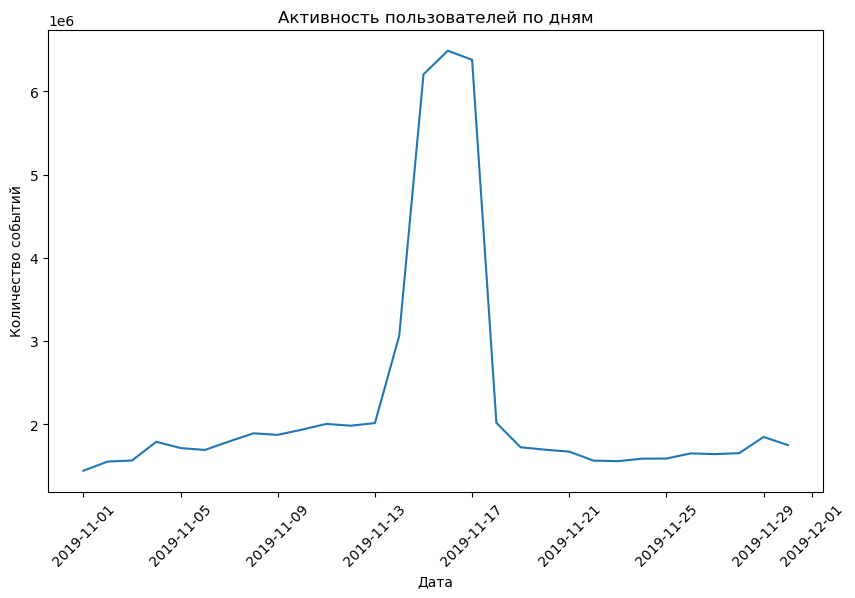

In [46]:
# Строим график активности
plt.figure(figsize=(10,6))
sns.lineplot(data=event_counts)
plt.title('Активность пользователей по дням')
plt.ylabel('Количество событий')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.show()

Активность пользователей показывает заметные колебания. С 1 по 13 ноября активность находилась на низком уровне, затем наблюдается пик с 13 по 17 ноября, после чего активность снова снижается. Это может свидетельствовать о том, что в эти дни проходила акция или распродажа, привлекающая большее количество пользователей.

### 2. Анализ популярных категорий товаров:
Мы можем посмотреть, какие категории товаров наиболее часто просматриваются или заказываются.

In [47]:
# Группировка по категориям и типам событий
category_counts = df.groupby(['category_code', 'event_type']).size().unstack()

In [48]:
# Выбираем топ-10 популярных категорий
top_categories = category_counts.sum(axis=1).nlargest(10)

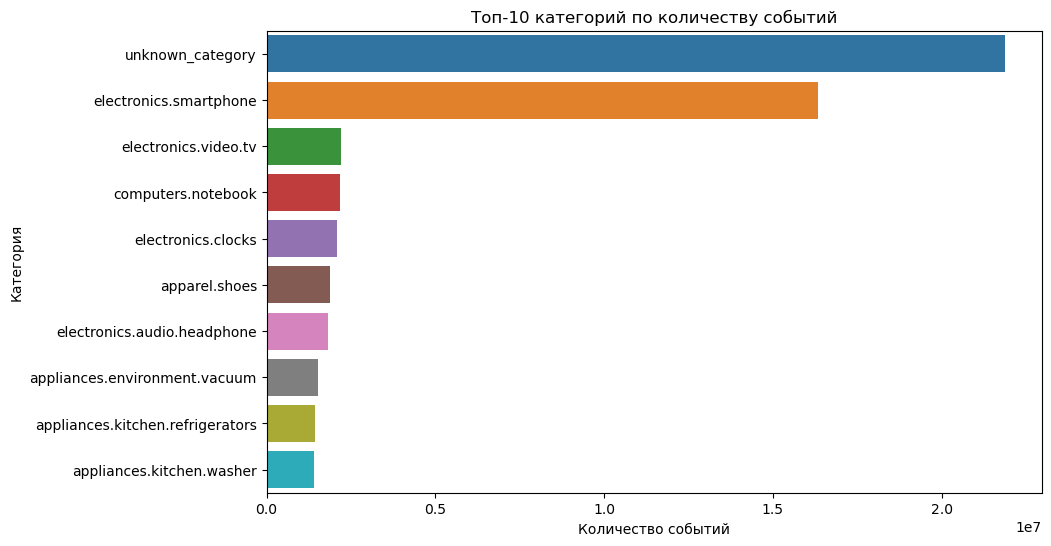

In [49]:
# Строим график для топ-10 категорий
plt.figure(figsize=(10,6))
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title('Топ-10 категорий по количеству событий')
plt.xlabel('Количество событий')
plt.ylabel('Категория')
plt.show()

Высокий уровень записей с категорией unknown_category может свидетельствовать о проблемах с качеством данных. Это может быть вызвано отсутствием информации о категориях товаров или ошибками при их загрузке. Следующая по популярности категория — electronics.smartphone (1.7 миллиона событий), что отражает высокий интерес пользователей к смартфонам. По причине высокого unknown_category, выводы о категориях становятся менее достоверными.

### 3. Анализ конверсии пользователей:
Посмотрим на конверсию — сколько пользователей переходит от просмотров к заказам.

In [50]:
# Количество уникальных пользователей, которые совершали каждый тип события
conversion_funnel = df.groupby('event_type')['user_id'].nunique()

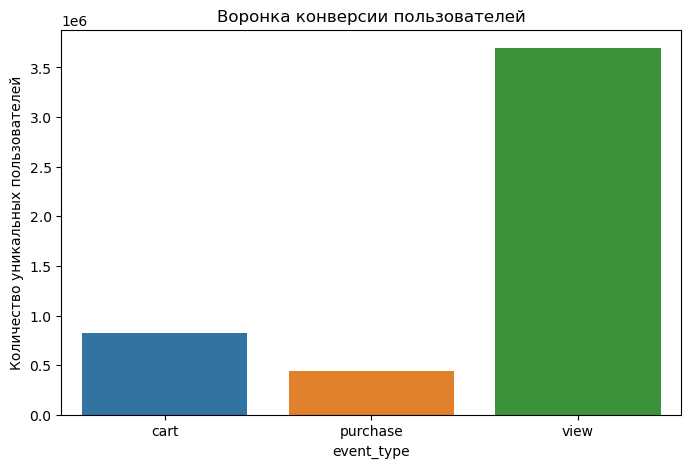

In [51]:
# Строим воронку конверсии
plt.figure(figsize=(8,5))
sns.barplot(x=conversion_funnel.index, y=conversion_funnel.values)
plt.title('Воронка конверсии пользователей')
plt.ylabel('Количество уникальных пользователей')
plt.show()

Количество событий показывает, что лишь небольшая часть пользователей переходит от просмотра товаров к добавлению их в корзину, и еще меньшая доля совершает покупку. Улучшение конверсии между этими этапами может значительно повысить продажи и стать целью для дальнейшего анализа и экспериментов.

# Шаг 4: Построение гипотез

Мы можем проверить несколько гипотез, основанных на анализе данных о поведении пользователей.

1. Гипотеза о кросс-продажах: предполагается, что пользователи, добавляющие товары из разных категорий в корзину, имеют более высокую склонность к покупке по сравнению с теми, кто ограничивается товарами из одной категории. Мы будем измерять конверсию пользователей с многокатегорийными корзинами и сравнивать её с конверсией пользователей, добавляющих товары из одной категории.

2. Гипотеза о частоте взаимодействия: мы предполагаем, что пользователи, активно взаимодействующие с контентом (например, кликами и просмотрами), имеют более высокую конверсию. Для проверки этой гипотезы мы рассчитаем количество взаимодействий для каждого пользователя и сравним его с уровнем конверсии.

3. Гипотеза о категориях товаров: некоторые категории могут демонстрировать более высокий коэффициент конверсии. Мы рассчитаем конверсию для каждой категории и выявим наиболее успешные.

4. Гипотеза о возвращающихся пользователях: предполагается, что возвращающиеся пользователи имеют более высокий уровень конверсии по сравнению с новыми. Мы сравним уровень конверсии для новых и возвращающихся пользователей.

# Шаг 5: Проверка гипотез
На этом этапе мы проверим наши гипотезы, используя различные методы. 

In [81]:
data = df.sample(frac=0.1, random_state=42)

### 1. Когортный анализ: Гипотеза о кросс-продажах

In [82]:
# Фильтруем события только по добавлению в корзину и покупкам
cart_events = data[data['event_type'].isin(['cart', 'purchase'])]

# Считаем уникальные категории для каждого пользователя и сессии
user_categories = cart_events.groupby(['user_id', 'user_session'])['category_code'].nunique().reset_index()
user_categories.columns = ['user_id', 'user_session', 'num_categories']

# Разделяем пользователей на две группы: добавляющие товары из одной категории и из нескольких
single_category = user_categories[user_categories['num_categories'] == 1]
multi_category = user_categories[user_categories['num_categories'] > 1]

# Объединяем данные о добавленных в корзину товарах с покупками
single_category_merged = single_category.merge(
    cart_events[cart_events['event_type'] == 'purchase'][['user_id', 'user_session']],
    on=['user_id', 'user_session'],
    how='left', indicator=True
)

multi_category_merged = multi_category.merge(
    cart_events[cart_events['event_type'] == 'purchase'][['user_id', 'user_session']],
    on=['user_id', 'user_session'],
    how='left', indicator=True
)

# Проверим, какие значения присутствуют в столбце _merge
print(single_category_merged['_merge'].value_counts())
print(multi_category_merged['_merge'].value_counts())

# Теперь считаем конверсию для каждой группы: 'both' означает, что сессия была и с добавлением в корзину, и с покупкой
single_category_conversion = (single_category_merged['_merge'] == 'both').mean()
multi_category_conversion = (multi_category_merged['_merge'] == 'both').mean()

# Вывод конверсий
print(f'Конверсия для одной категории: {single_category_conversion}')
print(f'Конверсия для нескольких категорий: {multi_category_conversion}')


_merge
left_only     253138
both           89491
right_only         0
Name: count, dtype: int64
_merge
both          2284
left_only     1978
right_only       0
Name: count, dtype: int64
Конверсия для одной категории: 0.2611892163243625
Конверсия для нескольких категорий: 0.5358986391365556


In [98]:
single_category

,user_id,user_session,num_categories
0,128968633,02cb7aa7-712e-49e9-aa86-e4368d1467ac,1
1,239198635,23014d2e-0647-4c12-af4b-aa13f738bbd3,1
2,251171183,c20b53ef-621c-407e-a895-940ca595d1c1,1
3,269003139,29f24176-f471-4236-bbe8-6ca94d5ecfaf,1
4,269597875,2073cf27-0b3f-41dc-8f75-5e1e689ba1a8,1
...,...,...,...
344752,579944616,c4dfaee3-e939-49f5-bcc4-f8674841739a,1
344753,579944655,f3521ead-f9d7-40dc-a6d5-75ffd8737789,1
344754,579946501,4f2fb970-3328-471c-a074-956517ac809d,1
344755,579957748,8d1e0711-1d15-40d6-9fa5-a660d168d95d,1


In [99]:
single_category_merged

,user_id,user_session,num_categories,_merge
0,128968633,02cb7aa7-712e-49e9-aa86-e4368d1467ac,1,left_only
1,239198635,23014d2e-0647-4c12-af4b-aa13f738bbd3,1,left_only
2,251171183,c20b53ef-621c-407e-a895-940ca595d1c1,1,left_only
3,269003139,29f24176-f471-4236-bbe8-6ca94d5ecfaf,1,left_only
4,269597875,2073cf27-0b3f-41dc-8f75-5e1e689ba1a8,1,left_only
...,...,...,...,...
342624,579944616,c4dfaee3-e939-49f5-bcc4-f8674841739a,1,left_only
342625,579944655,f3521ead-f9d7-40dc-a6d5-75ffd8737789,1,left_only
342626,579946501,4f2fb970-3328-471c-a074-956517ac809d,1,left_only
342627,579957748,8d1e0711-1d15-40d6-9fa5-a660d168d95d,1,left_only


В когортном анализе мы увидели, что 26,1% пользователей, добавляющих товары из одной категории, совершают покупки, в то время как у тех, кто добавляет товары из нескольких категорий, этот показатель значительно выше — 53,6%. Это говорит о том, что кросс-продажи работают!

### 2. Сравнительный анализ: Гипотеза о частоте взаимодействия

In [85]:
# Подсчет частоты взаимодействий для каждого пользователя
user_activity = data.groupby('user_id')['event_type'].count().reset_index()
user_activity.columns = ['user_id', 'activity_count']

# Конверсия для пользователей
purchases = data[data['event_type'] == 'purchase'].groupby('user_id')['event_type'].count().reset_index()
purchases.columns = ['user_id', 'purchase_count']

# Объединяем данные
activity_conversion = user_activity.merge(purchases, on='user_id', how='left')
activity_conversion['purchase_count'] = activity_conversion['purchase_count'].fillna(0)
activity_conversion['converted'] = activity_conversion['purchase_count'] > 0

# Разделяем пользователей на активных и менее активных (например, медиана)
median_activity = activity_conversion['activity_count'].median()
high_activity = activity_conversion[activity_conversion['activity_count'] > median_activity]
low_activity = activity_conversion[activity_conversion['activity_count'] <= median_activity]

# Конверсия для высоко- и низкоактивных пользователей
high_conversion_rate = high_activity['converted'].mean()
low_conversion_rate = low_activity['converted'].mean()

# Статистическая проверка значимости разницы
t_stat, p_value = stats.ttest_ind(high_activity['converted'], low_activity['converted'])

# Вывод результатов
print(f'Конверсия для высокоактивных пользователей: {high_conversion_rate}')
print(f'Конверсия для низкоактивных пользователей: {low_conversion_rate}')
print(f't-stat: {t_stat}, p-value: {p_value}')


Конверсия для высокоактивных пользователей: 0.077420190705803
Конверсия для низкоактивных пользователей: 0.0193255481049068
t-stat: 193.14132948702655, p-value: 0.0


В сравнительном анализе мы обнаружили, что конверсия у высокоактивных пользователей составляет 7,74%, в то время как у менее активных — всего 1,93%. Это показывает, что активность пользователей напрямую связана с их покупательской способностью.

### 3. Когортный анализ: Гипотеза о категориях товаров

In [86]:
# Считаем количество покупок в каждой категории
category_conversion = data[data['event_type'] == 'purchase'].groupby('category_code')['event_type'].count().reset_index()
category_conversion.columns = ['category_code', 'purchase_count']

# Общее количество взаимодействий с каждой категорией (добавления в корзину или просмотры)
category_total = data.groupby('category_code')['event_type'].count().reset_index()
category_total.columns = ['category_code', 'total_interactions']

# Объединяем данные для расчета конверсии
category_data = category_conversion.merge(category_total, on='category_code', how='left')
category_data['conversion_rate'] = category_data['purchase_count'] / category_data['total_interactions']

# Вывод категорий с наибольшей и наименьшей конверсией
print(category_data.sort_values(by='conversion_rate', ascending=False))

                    category_code  purchase_count  total_interactions  \
109             kids.fmcg.diapers              90                3344   
91         electronics.smartphone           38236             1633423   
84    electronics.audio.headphone            4105              181397   
119           stationery.cartrige              27                1325   
39   appliances.kitchen.microwave             532               30820   
..                            ...             ...                 ...   
82        country_yard.lawn_mower               1                 675   
21              apparel.underwear               6                4736   
5                   apparel.dress              12                9509   
17                  apparel.skirt               1                 871   
81        country_yard.cultivator               1                 962   

     conversion_rate  
109         0.026914  
91          0.023409  
84          0.022630  
119         0.020377  
39      

Когортный анализ по категориям товаров показал, что наивысшая конверсия наблюдается у подгузников для детей (2,69%), а самая низкая — у садовой техники, как культиваторы (0,1%). Это подсказывает, что спрос на разные категории сильно варьируется.

### 4. Сравнительный анализ: Гипотеза о возвращающихся пользователях

In [87]:
# Определяем возвращающихся и новых пользователей по количеству уникальных дат посещения
user_visits = data.groupby(['user_id', 'event_date']).size().reset_index().groupby('user_id').size().reset_index()
user_visits.columns = ['user_id', 'visit_count']

# Разделяем на новые (1 визит) и возвращающихся (больше 1 визита)
new_users = user_visits[user_visits['visit_count'] == 1]
returning_users = user_visits[user_visits['visit_count'] > 1]

# Конверсия для новых и возвращающихся пользователей
new_user_conversion = new_users.merge(purchases, on='user_id', how='left')['purchase_count'].fillna(0).mean()
returning_user_conversion = returning_users.merge(purchases, on='user_id', how='left')['purchase_count'].fillna(0).mean()

# Статистический тест
t_stat, p_value = stats.ttest_ind(
    new_users.merge(purchases, on='user_id', how='left')['purchase_count'].fillna(0),
    returning_users.merge(purchases, on='user_id', how='left')['purchase_count'].fillna(0)
)

# Вывод результатов
print(f'Конверсия новых пользователей: {new_user_conversion}')
print(f'Конверсия возвращающихся пользователей: {returning_user_conversion}')
print(f't-stat: {t_stat}, p-value: {p_value}')


Конверсия новых пользователей: 0.022759195103567224
Конверсия возвращающихся пользователей: 0.09510175041599259
t-stat: -169.11924625777615, p-value: 0.0


В сравнительном анализе возвращающихся и новых пользователей конверсия у новых составляет 2,28%, а у возвращающихся — 9,51%. Это явное свидетельство того, что возвращающиеся пользователи гораздо чаще делают покупки.

# Шаг 5. Заключение и рекомендации

В этом проекте мы провели анализ поведения пользователей в интернет-магазине, чтобы понять, как они взаимодействуют с товарами и совершают покупки. В процессе мы изучили несколько ключевых аспектов:

Оказалось, что пользователи, которые добавляют товары из нескольких категорий, чаще совершают покупки по сравнению с теми, кто выбирает товары только из одной категории. Это может говорить о том, что интерес к разным товарам увеличивает вероятность покупки.

Возвращающиеся пользователи показали гораздо более высокую конверсию, чем новые. Например, конверсия среди вернувшихся составляет около 9,5%, в то время как у новых пользователей — всего 2,3%. Это явно говорит о том, что работа с уже вернувшимися клиентами может быть очень эффективной.

Что касается рекомендаций, имеет смысл больше внимания уделять тем, кто добавляет товары из разных категорий. Можно попробовать предложить им какие-то персонализированные скидки или акции. Также важно поработать над удержанием клиентов — программы лояльности, скидки для постоянных покупателей или продуманные рассылки могут помочь в этом. Ну и для новых пользователей стоит сделать первый опыт покупки более привлекательным, например, через приветственные предложения или бонусы.